**Name:** Byaravalli Arun Suhag

**EID:** 53265857

# CS4487 - Tutorial 4
## Face Detection in Images

In this tutorial you will train a classifier to detect whether there is a face in a small image patch.  This type of face detector is used in your phone and camera whenever you take a picture!

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import IPython.utils.warn as warn
random.seed(100)
from scipy import ndimage
from scipy import signal
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util

C:\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the images.

In [2]:
filelist = glob.glob('faces/*/*/*.png')

if len(filelist) == 0:
    warn.error("Could not find images in faces directory!  " + 
               "Make sure you put it here: " + os.getcwd() )
else:
    imgdata = {'train':[], 'test':[]}
    classes = {'train':[], 'test':[]}

    for f in filelist:
        img = skimage.io.imread(f)
        # convert to grayscale
        img = skimage.color.rgb2gray(img)

        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(f)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        imgdata[fset].append(img)
        classes[fset].append(myclass)
    imgsize = img.shape

testclass2start = sum(classes['test'])

# dataset is too big, so take a subset
subsample = 8  # reduce by a factor of 8
imgdata['train'] = imgdata['train'][::subsample]
classes['train'] = classes['train'][::subsample]
imgdata['test']  = imgdata['test'][:2*testclass2start]
classes['test']  = classes['test'][:2*testclass2start]
print len(imgdata['train'])
print len(imgdata['test'])

trainclass2start = sum(classes['train'])

873
944


Each image is a 19x19 array of pixel values.  Run the below code to show an example:

(19L, 19L)


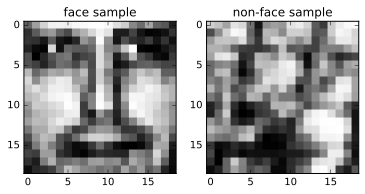

In [3]:
print img.shape
plt.subplot(1,2,1)
plt.imshow(imgdata['train'][0], cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(imgdata['train'][trainclass2start], cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

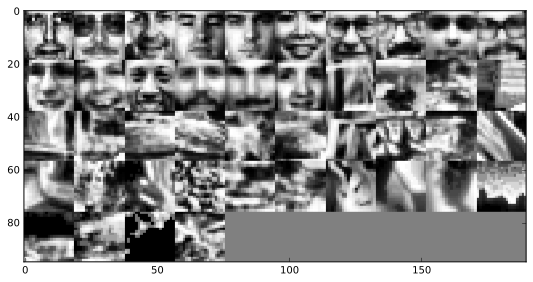

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show a few images
plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata['train'][::20]), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [5]:
trainX = empty((len(imgdata['train']), prod(imgsize)))
for i,img in enumerate(imgdata['train']):
    trainX[i,:] = ravel(img)
trainY = asarray(classes['train'])  # convert list to numpy array
print trainX.shape
print trainY.shape

testX = empty((len(imgdata['test']), prod(imgsize)))
for i,img in enumerate(imgdata['test']):
    testX[i,:] = ravel(img)
testY = asarray(classes['test'])  # convert list to numpy array
print testX.shape
print testY.shape

(873L, 361L)
(873L,)
(944L, 361L)
(944L,)


## 2. Detection using  pixel values

Train an AdaBoost classifier to classify an image patch as face or non-face.  Also train a kernel SVM classifier using either RBF or polynomial kernel, and a Random Forest Classifier.  Evaluate all your classifiers on the test set.

Don't forget to normalize your features!

In [15]:
### INSERT YOUR CODE HERE

# ADABOOST CLASSIFIER
# setup the list of parameters to try
paramgrid = {'n_estimators': array([1, 2, 3, 5, 2500]) }
print paramgrid

# setup the cross-validation object
adacv = grid_search.GridSearchCV(ensemble.AdaBoostClassifier(random_state=4487),
                                 paramgrid, cv=5)

# run cross-validation (train for each split)
adacv.fit(trainX, trainY);

print "best params:"
print adacv.best_params_

adaclf = adacv.best_estimator_
predY_ada = adaclf.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY_ada)
print "test accuracy for Adaboost=", acc

{'n_estimators': array([   1,    2,    3,    5, 2500])}
best params:
{'n_estimators': 2500}
test accuracy for Adaboost= 0.664194915254


In [10]:
## SVM linear 
paramgrid = {'C': logspace(-2,3,20)}

print paramgrid

# setup the cross-validation object
# pass the SVM object w/ rbf kernel, parameter grid, and number of CV folds
svmcvk = grid_search.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5)

# run cross-validation (train for each split)
svmcvk.fit(trainX, trainY);

print "best params for linear SVM:"
print svmcvk.best_params_


svmclfk = svmcvk.best_estimator_
predYSVMLinear = svmclfk.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYSVMLinear)
print "test accuracy for linear SVM =", acc



{'C': array([  1.00000000e-02,   1.83298071e-02,   3.35981829e-02,
         6.15848211e-02,   1.12883789e-01,   2.06913808e-01,
         3.79269019e-01,   6.95192796e-01,   1.27427499e+00,
         2.33572147e+00,   4.28133240e+00,   7.84759970e+00,
         1.43844989e+01,   2.63665090e+01,   4.83293024e+01,
         8.85866790e+01,   1.62377674e+02,   2.97635144e+02,
         5.45559478e+02,   1.00000000e+03])}
best params for linear SVM:
{'C': 1.2742749857031335}
test accuracy for linear SVM = 0.577330508475


In [11]:
## SVM with RBF kernel

paramgrid = {'C': logspace(-2,3,20), 
             'gamma': logspace(-4,3,20) }

print paramgrid

# setup the cross-validation object
# pass the SVM object w/ rbf kernel, parameter grid, and number of CV folds
svmcvrbf = grid_search.GridSearchCV(svm.SVC(kernel='rbf'), paramgrid, cv=5)

# run cross-validation (train for each split)
svmcvrbf.fit(trainX, trainY);

print "best params for SVM with RBF kernel:"
print svmcvrbf.best_params_

svmclfrbf = svmcvrbf.best_estimator_
predYSVMRBF = svmclfrbf.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYSVMRBF)
print "test accuracy for SVM with RBF kernel=", acc



{'C': array([  1.00000000e-02,   1.83298071e-02,   3.35981829e-02,
         6.15848211e-02,   1.12883789e-01,   2.06913808e-01,
         3.79269019e-01,   6.95192796e-01,   1.27427499e+00,
         2.33572147e+00,   4.28133240e+00,   7.84759970e+00,
         1.43844989e+01,   2.63665090e+01,   4.83293024e+01,
         8.85866790e+01,   1.62377674e+02,   2.97635144e+02,
         5.45559478e+02,   1.00000000e+03]), 'gamma': array([  1.00000000e-04,   2.33572147e-04,   5.45559478e-04,
         1.27427499e-03,   2.97635144e-03,   6.95192796e-03,
         1.62377674e-02,   3.79269019e-02,   8.85866790e-02,
         2.06913808e-01,   4.83293024e-01,   1.12883789e+00,
         2.63665090e+00,   6.15848211e+00,   1.43844989e+01,
         3.35981829e+01,   7.84759970e+01,   1.83298071e+02,
         4.28133240e+02,   1.00000000e+03])}
best params for SVM with RBF kernel:
{'C': 4.2813323987193916, 'gamma': 0.037926901907322501}
test accuracy for SVM with RBF kernel= 0.679025423729


In [13]:
## Random Forrest

paramgrid = {'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100]) }
print paramgrid

# setup the cross-validation object
rfcv = grid_search.GridSearchCV(
    ensemble.RandomForestClassifier(random_state=4487),
    paramgrid, cv=5)

# run cross-validation (train for each split)
rfcv.fit(trainX, trainY);

print "best params for Random Forest:"
print rfcv.best_params_

rfclf = rfcv.best_estimator_
predYRandomForrest = rfclf.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYRandomForrest)
print "test accuracy for Random Forest =", acc


{'n_estimators': array([  1,   2,   3,   5,  10,  15,  20,  25,  50, 100])}
best params for Random Forest:
{'n_estimators': 100}
test accuracy for Random Forest = 0.64406779661


_Which classifier was best?_
- **SVM with RBF performances slightly better than Adaboost and random forrest. Linear SVM performs much worse compared to the others. But overall the classification model is still not good enough as the accuracy lies between 60-70%.**

### Error analysis
The accuracy only tells part of the classifier's performance. We can also look at the different types of errors that the classifier makes:
- _True Positive (TP)_: classifier correctly said face
- _True Negative (TN)_: classifier correctly said non-face
- _False Positive (FP)_: classifier said face, but not a face
- _False Negative (FN)_: classifier said non-face, but was a face

This is summarized in the following table:

<table>
<tr><th colspan=2 rowspan=2><th colspan=2 style="text-align: center">Actual</th></tr>
<tr>  <th>Face</th><th>Non-face</th></tr>
<tr><th rowspan=2>Prediction</th><th>Face</th><td>True Positive (TP)</td><td>False Positive (FP)</td></tr>
<tr>  <th>Non-face</th><td>False Negative (FN)</td><td>True Negative (TN)</td></tr>
</table>

We can then look at the _true positive rate_ and the _false positive rate_.
- _true positive rate (TPR)_: proportion of true faces that were correctly detected
- _false positive rate (FPR)_: proportion of non-faces that were mis-classified as faces.

Use the below code to calculate the TPR and FPR of your classifiers.

In [17]:
# Error analysis for adaboost

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = sum(testY[Pind] == predY_ada[Pind])
FP = sum(testY[Pind] != predY_ada[Pind])
TN = sum(testY[Nind] == predY_ada[Nind])
FN = sum(testY[Nind] != predY_ada[Nind])

TPR = float(TP) / (TP+FN)
FPR = float(FP) / (FP+TN)
print "Error analysis for: THE ADABOOST CLASSIFIER"

print "TP="+str(TP)
print "FP="+str(FP)
print "TN="+str(TN)
print "FN="+str(FN)
print "TPR="+str(TPR)
print "FPR="+str(FPR)


# Error analysis for linear SVM

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = sum(testY[Pind] == predYSVMLinear[Pind])
FP = sum(testY[Pind] != predYSVMLinear[Pind])
TN = sum(testY[Nind] == predYSVMLinear[Nind])
FN = sum(testY[Nind] != predYSVMLinear[Nind])

TPR = float(TP) / (TP+FN)
FPR = float(FP) / (FP+TN)
print "Error analysis for: THE LINEAR SVM"

print "TP="+str(TP)
print "FP="+str(FP)
print "TN="+str(TN)
print "FN="+str(FN)
print "TPR="+str(TPR)
print "FPR="+str(FPR)

# Error analysis for RBF SVM

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = sum(testY[Pind] == predYSVMRBF[Pind])
FP = sum(testY[Pind] != predYSVMRBF[Pind])
TN = sum(testY[Nind] == predYSVMRBF[Nind])
FN = sum(testY[Nind] != predYSVMRBF[Nind])

TPR = float(TP) / (TP+FN)
FPR = float(FP) / (FP+TN)
print "Error analysis for: THE RBF SVM"

print "TP="+str(TP)
print "FP="+str(FP)
print "TN="+str(TN)
print "FN="+str(FN)
print "TPR="+str(TPR)
print "FPR="+str(FPR)

# Error analysis for Random Forrest

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = sum(testY[Pind] == predYRandomForrest[Pind])
FP = sum(testY[Pind] != predYRandomForrest[Pind])
TN = sum(testY[Nind] == predYRandomForrest[Nind])
FN = sum(testY[Nind] != predYRandomForrest[Nind])

TPR = float(TP) / (TP+FN)
FPR = float(FP) / (FP+TN)
print "Error analysis for: RANDOM FORREST"

print "TP="+str(TP)
print "FP="+str(FP)
print "TN="+str(TN)
print "FN="+str(FN)
print "TPR="+str(TPR)
print "FPR="+str(FPR)

Error analysis for: THE ADABOOST CLASSIFIER
TP=160
FP=312
TN=467
FN=5
TPR=0.969696969697
FPR=0.400513478819
Error analysis for: THE LINEAR SVM
TP=78
FP=394
TN=467
FN=5
TPR=0.939759036145
FPR=0.457607433217
Error analysis for: THE RBF SVM
TP=172
FP=300
TN=469
FN=3
TPR=0.982857142857
FPR=0.390117035111
Error analysis for: RANDOM FORREST
TP=145
FP=327
TN=463
FN=9
TPR=0.941558441558
FPR=0.413924050633


_How does the classifier make errors?_
- **(For all the above classifiers) Since the number of false positives(FN) and the false positive rate(FPR) is high, it is evident that the classifier makes a lot of errors by classifying the 'not-face' class images into the 'face' class.**


### Classifier analysis

For the AdaBoost classifier, we can interpret what it is doing by looking at which features it uses most in the weak learners.  Use the below code to visualize the pixel features used.

Note: if you used GridSearchCV to train the classifier, then you need to use the `best_estimator_` field to access the classifier.

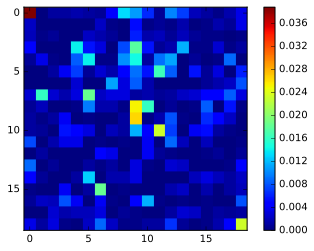

In [18]:
# adaclf is the trained adaboost classifier
fi = adaclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly for Random Forests, we can look at the important features.

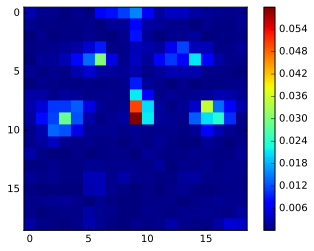

In [19]:
# rfclf is the trained random forest classifier
fi = rfclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Comment on which features (pixels) that AdaBoost and Random Forests are using
- **INSERT YOUR ANSWER HERE**


For kernel SVM, we can look at the support vectors to see what the classifier finds difficult.

 num support vectors: 97


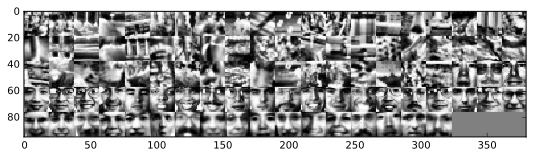

In [22]:
# svmclf is the trained SVM linear classifier

print "num support vectors:", len(svmclfk.support_vectors_)
si  = svmclfk.support_  # get indicies of support vectors

# get all the patches for each support vector
simg = [ imgdata['train'][i] for i in si ]

# make montage
outimg = image_montage(simg, maxw=20)

plt.figure(figsize=(9,9))
plt.imshow(outimg, cmap='gray', interpolation='nearest')

num support vectors: 263


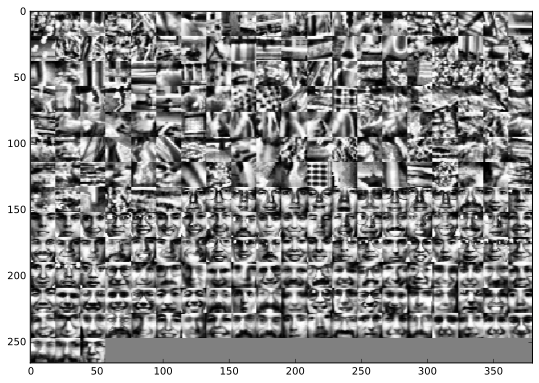

In [23]:
# svmclf is the trained SVM RBF classifier

print "num support vectors:", len(svmclfrbf.support_vectors_)
si  = svmclfrbf.support_  # get indicies of support vectors

# get all the patches for each support vector
simg = [ imgdata['train'][i] for i in si ]

# make montage
outimg = image_montage(simg, maxw=20)

plt.figure(figsize=(9,9))
plt.imshow(outimg, cmap='gray', interpolation='nearest')

Comment on anything you notice about what the SVM finds difficult (i.e., on the decision boundary or within the margin)
- ** In genral the above Two SVM algorithms in this case found it difficult to maximize the distance between the support vector points and the decision boundary, thus it can result in a large number of misclassifications (as a lot of points may have been very close to the boundary).This is the reason for low test accuracy from before. **
- **Also, the distance between the margins and the decision boundary may have been very little, not providing enough room for the decision boundary to wiggle around. **


## 3. Image Feature Extraction
The detection performance is not that good. The problem is that we are using the raw pixel values as features, so it is difficult for the classifier to interpret larger structures of the face that might be important.  To fix the problem, we will extract features from the image using a set of filters.

Run the below code to look at the filter output.  The filters are a sets of black and white boxes that respond to similar structures in the image.  After applying the filters to the image, the filter response map is aggregated over a 4x4 window.  Hence each filter produces a 5x5 feature response.  Since there are 4 filters, then the feature vector is 100 dimensions.

In [24]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),  
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)        
    fs = prod(tmpimg.shape)
    
    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)
            
            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.interpolation.zoom(imgk, 0.25)
    
            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)
               
            if (doplot):             
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x
    
    return X

C:\Anaconda2\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


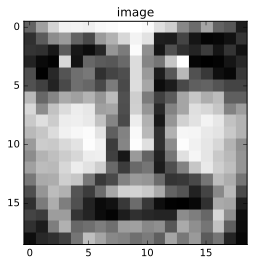

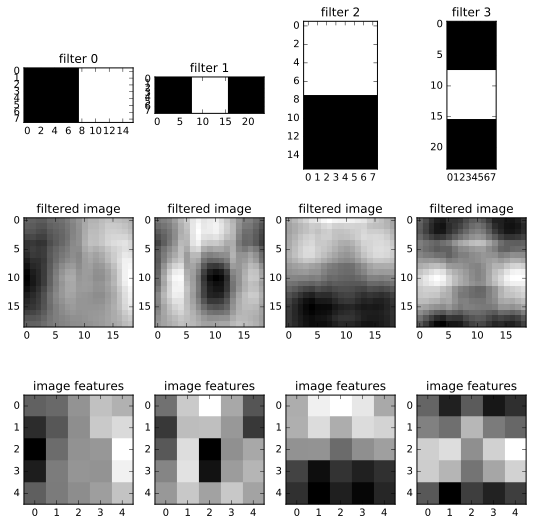

In [25]:
# new features
img = imgdata['train'][0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("image")
plt.figure(figsize=(9,9))
extract_features([img], doplot=True);

Now lets extract image features on the training and test sets.  It may take a few seconds.

In [26]:
trainXf = extract_features(imgdata['train'])
print trainXf.shape
testXf = extract_features(imgdata['test'])
print testXf.shape

(873L, 100L)
(944L, 100L)


### Detection using Image Features
Now train AdaBoost and SVM classifiers on the image feature data.  Evaluate on the test set.

In [31]:
### INSERT YOUR CODE HERE

paramgrid = {'n_estimators': array([1, 2, 3, 5, 2500, 500, 5000]) }
print paramgrid

# setup the cross-validation object
adacv = grid_search.GridSearchCV(ensemble.AdaBoostClassifier(random_state=4487),
                                 paramgrid, cv=5)

# run cross-validation (train for each split)
adacv.fit(trainXf, trainY);

print "best params:"
print adacv.best_params_

adaclf = adacv.best_estimator_
predY_ada = adaclf.predict(testXf)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY_ada)
print "test accuracy for Adaboost=", acc

{'n_estimators': array([   1,    2,    3,    5, 2500,  500, 5000])}
best params:
{'n_estimators': 5000}
test accuracy for Adaboost= 0.789194915254


In [32]:
## SVM linear 
paramgrid = {'C': logspace(-2,3,20)}

print paramgrid

# setup the cross-validation object
# pass the SVM object w/ rbf kernel, parameter grid, and number of CV folds
svmcvk = grid_search.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5)

# run cross-validation (train for each split)
svmcvk.fit(trainXf, trainY);

print "best params for linear SVM:"
print svmcvk.best_params_


svmclfk = svmcvk.best_estimator_
predYSVMLinear = svmclfk.predict(testXf)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYSVMLinear)
print "test accuracy for linear SVM =", acc

{'C': array([  1.00000000e-02,   1.83298071e-02,   3.35981829e-02,
         6.15848211e-02,   1.12883789e-01,   2.06913808e-01,
         3.79269019e-01,   6.95192796e-01,   1.27427499e+00,
         2.33572147e+00,   4.28133240e+00,   7.84759970e+00,
         1.43844989e+01,   2.63665090e+01,   4.83293024e+01,
         8.85866790e+01,   1.62377674e+02,   2.97635144e+02,
         5.45559478e+02,   1.00000000e+03])}
best params for linear SVM:
{'C': 0.018329807108324356}
test accuracy for linear SVM = 0.712923728814


In [33]:
## SVM with RBF kernel

paramgrid = {'C': logspace(-2,3,20), 
             'gamma': logspace(-4,3,20) }

print paramgrid

# setup the cross-validation object
# pass the SVM object w/ rbf kernel, parameter grid, and number of CV folds
svmcvrbf = grid_search.GridSearchCV(svm.SVC(kernel='rbf'), paramgrid, cv=5)

# run cross-validation (train for each split)
svmcvrbf.fit(trainXf, trainY);

print "best params for SVM with RBF kernel:"
print svmcvrbf.best_params_

svmclfrbf = svmcvrbf.best_estimator_
predYSVMRBF = svmclfrbf.predict(testXf)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYSVMRBF)
print "test accuracy for SVM with RBF kernel=", acc



{'C': array([  1.00000000e-02,   1.83298071e-02,   3.35981829e-02,
         6.15848211e-02,   1.12883789e-01,   2.06913808e-01,
         3.79269019e-01,   6.95192796e-01,   1.27427499e+00,
         2.33572147e+00,   4.28133240e+00,   7.84759970e+00,
         1.43844989e+01,   2.63665090e+01,   4.83293024e+01,
         8.85866790e+01,   1.62377674e+02,   2.97635144e+02,
         5.45559478e+02,   1.00000000e+03]), 'gamma': array([  1.00000000e-04,   2.33572147e-04,   5.45559478e-04,
         1.27427499e-03,   2.97635144e-03,   6.95192796e-03,
         1.62377674e-02,   3.79269019e-02,   8.85866790e-02,
         2.06913808e-01,   4.83293024e-01,   1.12883789e+00,
         2.63665090e+00,   6.15848211e+00,   1.43844989e+01,
         3.35981829e+01,   7.84759970e+01,   1.83298071e+02,
         4.28133240e+02,   1.00000000e+03])}
best params for SVM with RBF kernel:
{'C': 4.2813323987193916, 'gamma': 0.0001}
test accuracy for SVM with RBF kernel= 0.779661016949


In [34]:
## Random Forrest

paramgrid = {'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100]) }
print paramgrid

# setup the cross-validation object
rfcv = grid_search.GridSearchCV(
    ensemble.RandomForestClassifier(random_state=4487),
    paramgrid, cv=5)

# run cross-validation (train for each split)
rfcv.fit(trainXf, trainY);

print "best params for Random Forest:"
print rfcv.best_params_

rfclf = rfcv.best_estimator_
predYRandomForrest = rfclf.predict(testXf)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYRandomForrest)
print "test accuracy for Random Forest =", acc


{'n_estimators': array([  1,   2,   3,   5,  10,  15,  20,  25,  50, 100])}
best params for Random Forest:
{'n_estimators': 50}
test accuracy for Random Forest = 0.807203389831


### Error Analysis
Repeat the error analysis for the new classifiers.

In [35]:
# Error analysis for adaboost

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = sum(testY[Pind] == predY_ada[Pind])
FP = sum(testY[Pind] != predY_ada[Pind])
TN = sum(testY[Nind] == predY_ada[Nind])
FN = sum(testY[Nind] != predY_ada[Nind])

TPR = float(TP) / (TP+FN)
FPR = float(FP) / (FP+TN)
print "Error analysis for: THE ADABOOST CLASSIFIER"

print "TP="+str(TP)
print "FP="+str(FP)
print "TN="+str(TN)
print "FN="+str(FN)
print "TPR="+str(TPR)
print "FPR="+str(FPR)


# Error analysis for linear SVM

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = sum(testY[Pind] == predYSVMLinear[Pind])
FP = sum(testY[Pind] != predYSVMLinear[Pind])
TN = sum(testY[Nind] == predYSVMLinear[Nind])
FN = sum(testY[Nind] != predYSVMLinear[Nind])

TPR = float(TP) / (TP+FN)
FPR = float(FP) / (FP+TN)
print "Error analysis for: THE LINEAR SVM"

print "TP="+str(TP)
print "FP="+str(FP)
print "TN="+str(TN)
print "FN="+str(FN)
print "TPR="+str(TPR)
print "FPR="+str(FPR)

# Error analysis for RBF SVM

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = sum(testY[Pind] == predYSVMRBF[Pind])
FP = sum(testY[Pind] != predYSVMRBF[Pind])
TN = sum(testY[Nind] == predYSVMRBF[Nind])
FN = sum(testY[Nind] != predYSVMRBF[Nind])

TPR = float(TP) / (TP+FN)
FPR = float(FP) / (FP+TN)
print "Error analysis for: THE RBF SVM"

print "TP="+str(TP)
print "FP="+str(FP)
print "TN="+str(TN)
print "FN="+str(FN)
print "TPR="+str(TPR)
print "FPR="+str(FPR)

# Error analysis for Random Forrest

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = sum(testY[Pind] == predYRandomForrest[Pind])
FP = sum(testY[Pind] != predYRandomForrest[Pind])
TN = sum(testY[Nind] == predYRandomForrest[Nind])
FN = sum(testY[Nind] != predYRandomForrest[Nind])

TPR = float(TP) / (TP+FN)
FPR = float(FP) / (FP+TN)
print "Error analysis for: RANDOM FORREST"

print "TP="+str(TP)
print "FP="+str(FP)
print "TN="+str(TN)
print "FN="+str(FN)
print "TPR="+str(TPR)
print "FPR="+str(FPR)

Error analysis for: THE ADABOOST CLASSIFIER
TP=292
FP=180
TN=453
FN=19
TPR=0.938906752412
FPR=0.284360189573
Error analysis for: THE LINEAR SVM
TP=216
FP=256
TN=457
FN=15
TPR=0.935064935065
FPR=0.35904628331
Error analysis for: THE RBF SVM
TP=274
FP=198
TN=462
FN=10
TPR=0.964788732394
FPR=0.3
Error analysis for: RANDOM FORREST
TP=312
FP=160
TN=450
FN=22
TPR=0.934131736527
FPR=0.262295081967


How has the classifier using image features improved?
- **All the classifiers have significant increase in accuracy when image freature extraction is used.**


# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [27]:
fname = "nasa-small.png"

(210L, 480L)


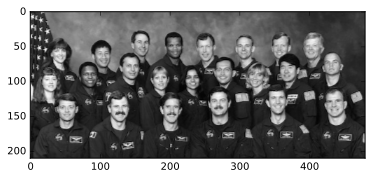

In [28]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print testimg.shape
plt.imshow(testimg, cmap='gray')

In [29]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
print patches2.shape 

# histogram equalize patches (improves contrast)
patches3 = empty(patches2.shape)
for i in range(patches2.shape[0]):
    patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

# extract features
newXf = extract_features(patches3)

(5568L, 19L, 19L)


Now predict using your classifier.  The extracted features are in `newXf`.

# Adaboost

In [36]:
### YOUR CODE HERE


prednewY = adaclf.predict(newXf)


Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

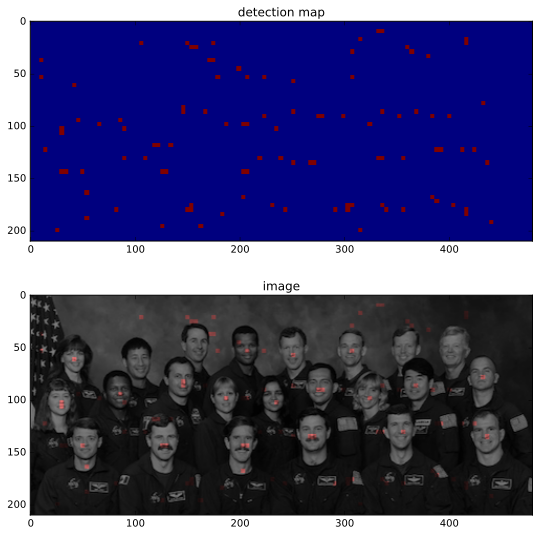

In [37]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do?_
- **The face detector was able to detect most of the faces (or roughly the centre of the faces), except 4 faces.**
- **There were however a lot of false positives, as some spaces between the astonauts and even the wall above the astronauts were (mis)classified as faces.**

# SVM linear

(-0.5, 479.5, 209.5, -0.5)

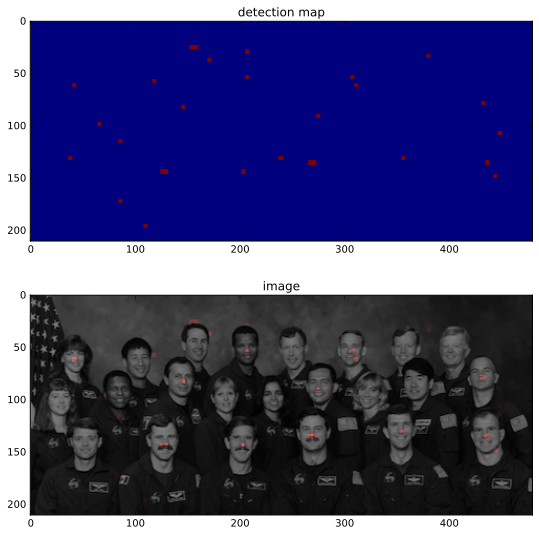

In [38]:
### YOUR CODE HERE


prednewY = svmclfk.predict(newXf)

# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')


How did your face detector do?
- **The face detector was able to detect only a handful of faces (or roughly the centre of the faces) and did not detect 11 faces.**
- **There were however fewe false positives compared to adaboost.**

# SVM RBF 

(-0.5, 479.5, 209.5, -0.5)

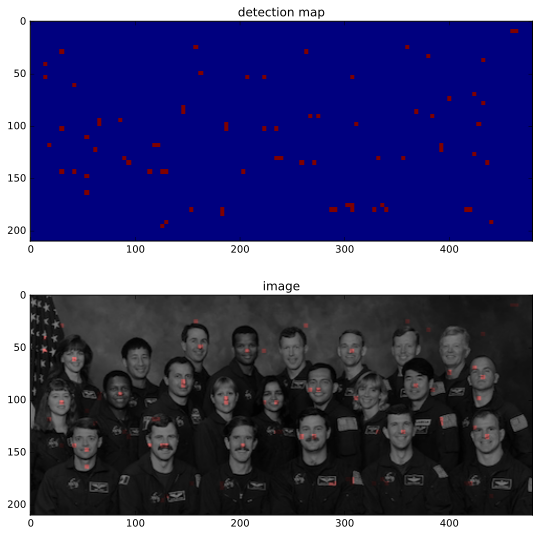

In [39]:
### YOUR CODE HERE


prednewY = svmclfrbf.predict(newXf)

# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')


How did your face detector do?
- **The face detector was able to detect most of the faces (or roughly the centre of the faces), except 3 faces. (better performance than adaboost and Linear SVM)**
- **There were however a few false positives compared to adaboost and Linear SVM**

# Random Forrest

(-0.5, 479.5, 209.5, -0.5)

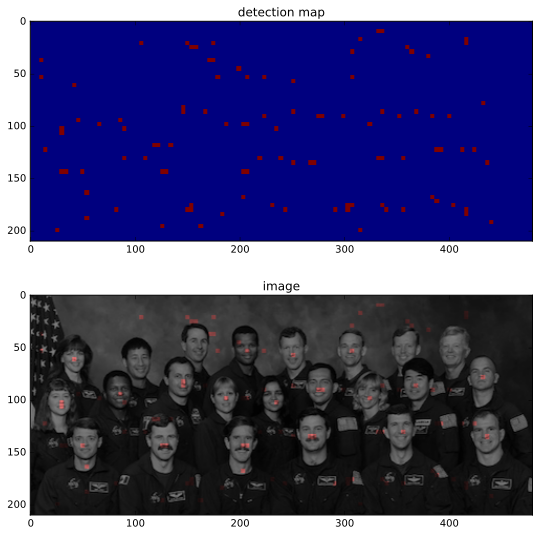

In [40]:
### YOUR CODE HERE


prednewY = adaclf.predict(newXf)

# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')


How did your face detector do?
- **The face detector was able to detect most of the faces (or roughly the centre of the faces), except 3 faces. (same performance level as SVM RBF)**
- **There were however a few false positives (better than Adaboost but worse than SVM), as the wall above the astronauts were (mis)classified as faces.**

Other things to try:
- You can try it on your own images.  The faces should all be around 19x19 pixels though.
- We only used 1/8 of the training data. Try using more data to train it!